In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

---



### SUMMARY

1. [Read the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Preprocessing](#3)
4. [Text Classification with Naive Bayes](#4)
5. [Text Classification with HF Transformers](#5)

---

# 1. Read the Data
<a id="1"></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

import torch
import transformers
import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer,AutoModel,TrainingArguments
from transformers import AutoModelForSequenceClassification,AutoConfig
from transformers import Trainer,BertModel,BertForSequenceClassification
from transformers import DataCollatorWithPadding

from warnings import simplefilter
simplefilter("ignore")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [ ]:
!pip install wandb

import wandb

In [ ]:
!pip install evaluate

import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
# data = pd.read_csv('WELFake_Dataset.csv')

# data.head()

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/data/WELFake_Dataset.csv')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Before moving to a quick analysis of the null and duplicate values, I am dropping the 'Unnamed: 0' column and also renaming the 'label' column.

In [ ]:
data.drop('Unnamed: 0',axis=1,inplace=True)

data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


I have renamed a column because HuggingFace transformers recognize 'labels' rather than 'label' as target column name.

In [ ]:
data.shape

(72134, 3)

**Null and duplicate values**

In [ ]:
# Null values
data.isna().sum()

,0
title,558
text,39
labels,0


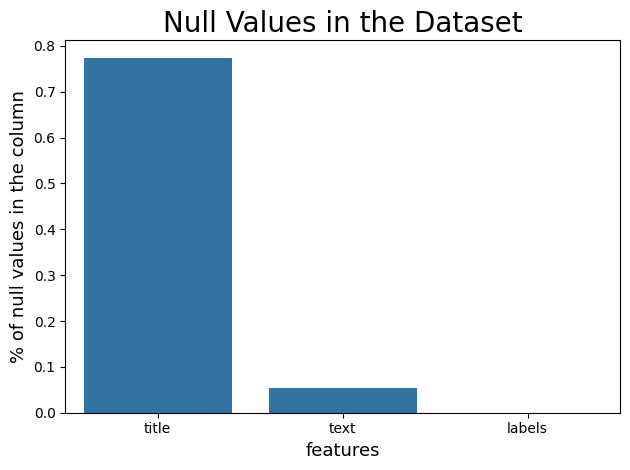

In [ ]:
def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')

I am dropping the nulls because they are less than 1% of the total entries.

In [ ]:
data.dropna(axis=0,inplace=True)

In [ ]:
# Duplicate values (or better, duplicate rows)
data.duplicated().sum()

np.int64(8416)

There are more than 8000 duplicate rows. I am dropping them.

In [ ]:
data.drop_duplicates(inplace=True)

data.shape

(63121, 3)

One can verify that the numbers of rows after removing the duplicates dropped from around 72k to almost 64k.



Then, I am **shuffling the data.**

In [ ]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

# 2. Exploratory Data Analysis

<a id="2"></a>

## 2.1 Target Class Balance/Imbalance

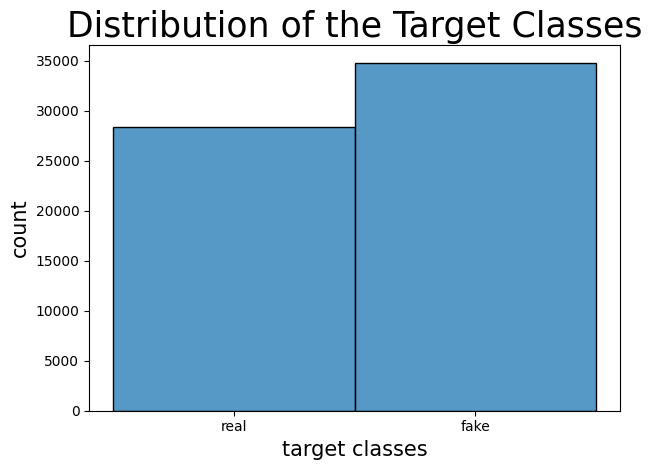

In [ ]:
# Creating a column with 'readable' labels for the news
news_map = {1:'real',0:'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

The target classes are slightly unbalanced, but it is nothing to worry about.

## 2.2 Number of Tokens in the Title and the Text Columns

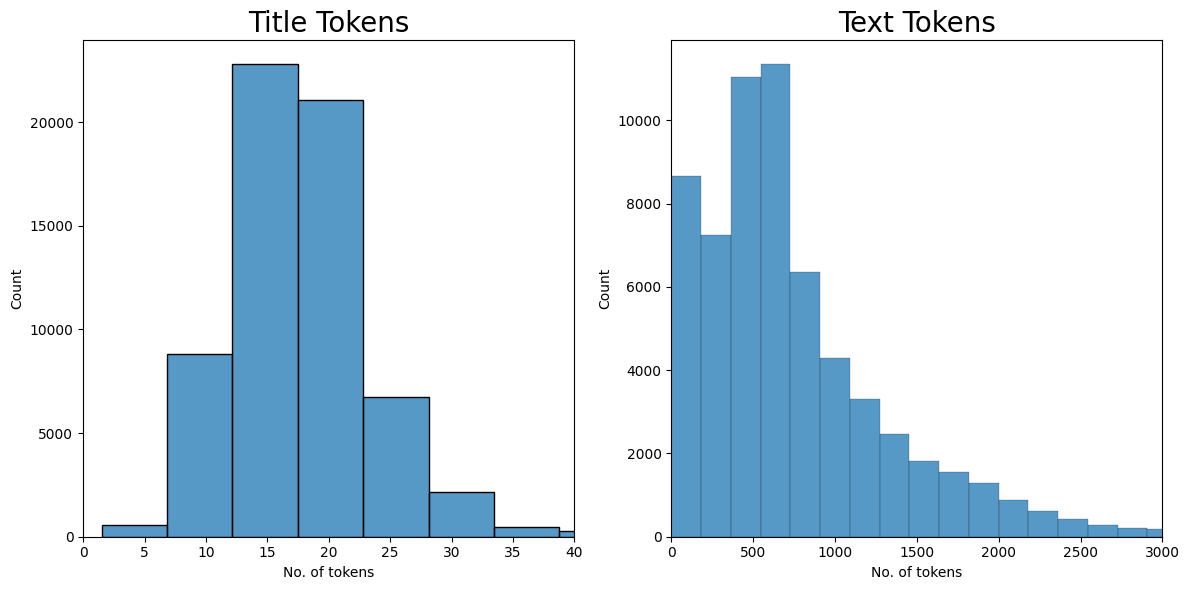

In [ ]:
####################################
# In general one has 1.5 tokens per word on average
title_tokens = data['title'].apply(lambda x: len(x.split())*1.5)
text_tokens  = data['text'].apply(lambda x: len(x.split())*1.5)
####################################

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.histplot(title_tokens,ax=ax1,bins=20)
ax1.set_xlabel('No. of tokens')
ax1.set_title("Title Tokens",fontsize=20)
ax1.set_xlim(0,40)

ax2 = sns.histplot(text_tokens,ax=ax2,bins=200)
ax2.set_xlabel('No. of tokens')
ax2.set_title("Text Tokens",fontsize=20)
ax2.set_xlim(0,3000)

plt.tight_layout()

These two distributions are completely different. In particular, the first one has much less tokens. Because of this, it is easier to be dealt with. This is why I will perform the fake news detection on the title column.

## 2.3 Average Number of Words in the Real/Fake News Titles

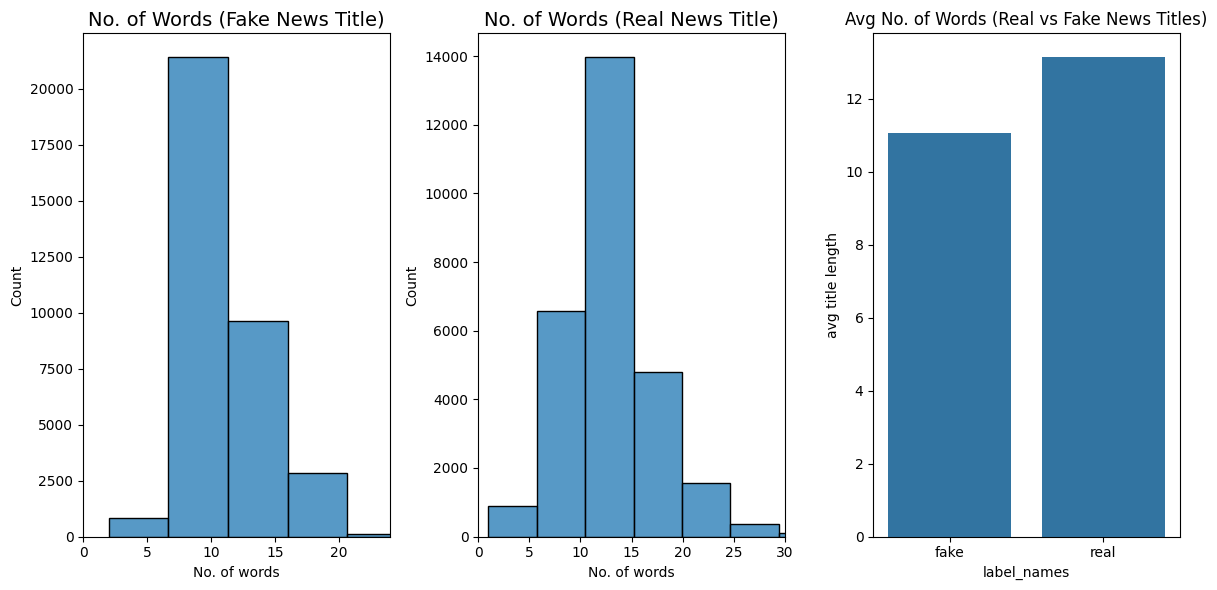

In [ ]:
##########################
fake_title = data.loc[data.labels == 0]['title'].apply(lambda x: len(x.split()))
real_title = data.loc[data.labels == 1]['title'].apply(lambda x: len(x.split()))

data['title_length'] = data['title'].apply(lambda x: len(x.split()))

avg_title = data.groupby('label_names')['title_length'].mean().reset_index(name='avg title length')
##########################

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(fake_title,ax=ax1,bins=6)
ax1.set_xlim(0,24)
ax1.set_xlabel('No. of words')
ax1.set_title("No. of Words (Fake News Title)",fontsize=14)

ax2 = sns.histplot(real_title,ax=ax2,bins=15)
ax2.set_xlim(0,30)
ax2.set_xlabel('No. of words')
ax2.set_title("No. of Words (Real News Title)",fontsize=14)

ax3 = sns.barplot(data=avg_title,x='label_names',y='avg title length')
ax3.set_title("Avg No. of Words (Real vs Fake News Titles)",fontsize=12)

plt.tight_layout()

## 2.4 Most Frequent Words in the Real/Fake News Titles

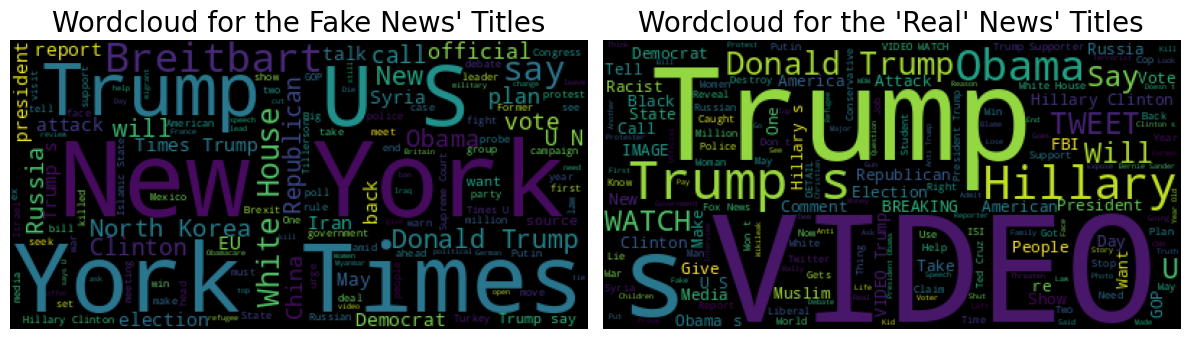

In [ ]:
text_fake = ' '.join(data.loc[data.labels == 0]['title'])
text_real = ' '.join(data.loc[data.labels == 1]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

<a id="3"></a>

I am removing unnecessary characteres from the text. I am also converting it into lower case.

In [ ]:
nlp = spacy.load("en_core_web_sm")

data2 = data.copy()


def clean_text(text):

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    return text


data2['title'] = data2['title'].apply(clean_text)

I am also dropping some columns that I will not use in the title text classification.

In [ ]:
data2.drop(columns=['text','title_length'],axis=1,inplace=True)

data2.rename(columns={'title':'text'},inplace=True)

data2.head()

,text,labels,label_names
71361,donald trump responds to mockery over fake sw...,1,real
11496,tweetwave,1,real
20292,rubio says prospect of trump president is worr...,0,fake
38855,trump lifts cyber command status to boost cybe...,0,fake
20416,the biggest republican lies about the economy...,1,real


# 4. Text Classification with Naive Bayes
<a id="4"></a>

I am performing train-test split.

In [ ]:
data3 = data2.copy()

X = data3['text']
y = data3['labels']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

I am creating a pipeline to vectorize the text and then fit the model to the data.

In [ ]:
# Create tokenization and modelling pipeline
model_NB = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf",MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_NB.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

Then, I am getting the score on the test data.

In [ ]:
test_score = model_NB.score(X_test,y_test)

test_score

0.8790727147911496

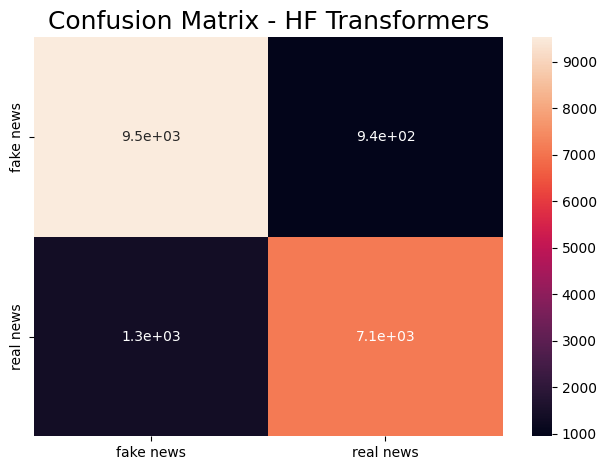

In [ ]:
y_pred = model_NB.predict(X_test)

# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

# 5. Text Classification with HF Transformers
<a id="5"></a>

## 5.1 Tokenization

I am importing the tokenizer.

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_ckpt = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Check vocabulary size
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

I am performing train-test-validation split ...

In [ ]:
# Train-test-validation split
train,test      = train_test_split(data2,test_size=0.3,stratify=data2['labels'])
test,validation = train_test_split(test,test_size=1/3,stratify=test['labels'])

train.shape, test.shape, validation.shape

((44184, 3), (12624, 3), (6313, 3))

... and then converting the dataset into a dictionary.

In [ ]:
# Convert dataframe to dictionary
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation': Dataset.from_pandas(validation,preserve_index=False)
     }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 44184
    })
    test: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 12624
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 6313
    })
})

Let's have a look at some entries.

In [ ]:
dataset['train'][0], dataset['train'][1], dataset['train'][2]

({'text': 'taxpayers will defend trump in suit charging constitutional violations the new york times',
  'labels': 0,
  'label_names': 'fake'},
 {'text': 'unions brace for probusiness shift in labor policy under trump',
  'labels': 0,
  'label_names': 'fake'},
 {'text': 'dead pool diva huma kept those hillary emails fbi found in a folder marked ‘life insurance’',
  'labels': 1,
  'label_names': 'real'})

In [ ]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding=True,truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 26457, 2097, 6985, 8398, 1999, 4848, 13003, 6543, 13302, 1996, 2047, 2259, 2335, 102], [101, 9209, 17180, 2005, 4013, 8286, 9961, 5670, 1999, 4450, 3343, 2104, 8398, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


In [ ]:
# batch_size = None ==> all data passed without any batch size
encoded_dataset = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/44184 [00:00<?, ? examples/s]

Map:   0%|          | 0/12624 [00:00<?, ? examples/s]

Map:   0%|          | 0/6313 [00:00<?, ? examples/s]

I am performing a mapping betwwen labels (0 and 1) and label names ('fake', 'real').

In [ ]:
# label2id, id2label: mapping between labels (0, 1, 2 ...) and label names (love, fear, surprise ...)
label2id = {x['label_names']:x['labels'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'fake': 0, 'real': 1}, {0: 'fake', 1: 'real'})

## 5.2 Training the Classifier Model

I am installing PEFT (Parameter-Efficient Fine-Tuning). This is a technique used in machine learning for the fine-tuning of large pre-trained models like transformers (e.g., BERT, GPT, etc.).

In [ ]:
!pip install peft

from peft import PeftModel,PeftConfig,get_peft_model,LoraConfig

I need to config the parameters of PEFT. Their choice is important to optimize the training of our model.

In [ ]:
num_labels = len(label2id)

# Where to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)

# to(device) ==> the model will be trained on cuda (GPU)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    # Rank: original matrix decomposed into 32 rows and columns
    r=32,
    # lora_alpha: scaling factor
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules = ["query"]
)

model = get_peft_model(model,peft_config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then, I am setting the training arguments.

In [ ]:
batch_size = 16

training_dir = "bert_base_train_dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy='epoch',  # Changed from evaluation_strategy
                                  disable_tqdm=False
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


I have to build my own metric, because there is none in Transformers.

In [ ]:
# Build compute metrics function
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels,preds)

    return {"accuracy":acc}

Finally, I can train the model.

In [ ]:
# Use data_collector to convert the samples to PyTorch tensors and concatenate them with the correct amount of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['validation'],
                  tokenizer=tokenizer,
                  data_collator=data_collator)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.336000,0.298566,0.884366
2,0.296900,0.270465,0.895612
3,0.268800,0.268339,0.898147
4,0.271900,0.260409,0.898463
5,0.272600,0.257862,0.901948


TrainOutput(global_step=13810, training_loss=0.30410741354398846, metrics={'train_runtime': 3071.5894, 'train_samples_per_second': 71.924, 'train_steps_per_second': 4.496, 'total_flos': 1.20027780007632e+16, 'train_loss': 0.30410741354398846, 'epoch': 5.0})

## 5.3 Model Evaluation

Now, it is time to evaluate the model on the test data.

In [ ]:
preds_output = trainer.predict(encoded_dataset['test'])

In [ ]:
preds_output.metrics

{'test_loss': 0.25746676325798035,
 'test_accuracy': 0.9014575411913816,
 'test_runtime': 61.3282,
 'test_samples_per_second': 205.843,
 'test_steps_per_second': 12.865}

In [ ]:
y_pred = np.argmax(preds_output.predictions,axis=1)

y_true = encoded_dataset['test'][:]['labels']

In [ ]:
print(classification_report(y_true,y_pred,target_names=list(label2id)))

              precision    recall  f1-score   support

        fake       0.90      0.92      0.91      6958
        real       0.90      0.88      0.89      5666

    accuracy                           0.90     12624
   macro avg       0.90      0.90      0.90     12624
weighted avg       0.90      0.90      0.90     12624



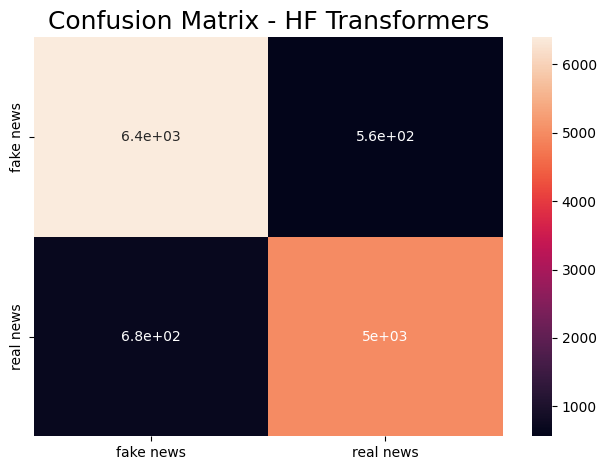

In [ ]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_true,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [ ]:
model.save_pretrained("bert_fake_news_model_v1")
tokenizer.save_pretrained("bert_fake_news_model_v1")

('bert_fake_news_model_v1/tokenizer_config.json',
 'bert_fake_news_model_v1/special_tokens_map.json',
 'bert_fake_news_model_v1/vocab.txt',
 'bert_fake_news_model_v1/added_tokens.json',
 'bert_fake_news_model_v1/tokenizer.json')

In [ ]:
!cp -r bert_fake_news_model_v1 /content/drive/MyDrive/data/

In [ ]:
!pip install huggingface_hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from huggingface_hub import HfApi

api = HfApi()

In [ ]:
# Load HF token from environment variable
HF_TOKEN = os.getenv('HF_TOKEN')
if not HF_TOKEN:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face API token")

api.upload_folder(
    folder_path="/content/drive/MyDrive/data/bert_fake_news_model_v1",
    repo_id="MounieshKing/fake_news_model_v1",
    repo_type="model",
    token=HF_TOKEN
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ..._model_v1/adapter_model.safetensors:  24%|##3       |  559kB / 2.37MB            

CommitInfo(commit_url='https://huggingface.co/MounieshKing/fake_news_model_v1/commit/bb2ea3a221c5fc84ce38ad8fbe4efb0f3337974d', commit_message='Upload folder using huggingface_hub', commit_description='', oid='bb2ea3a221c5fc84ce38ad8fbe4efb0f3337974d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MounieshKing/fake_news_model_v1', endpoint='https://huggingface.co', repo_type='model', repo_id='MounieshKing/fake_news_model_v1'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline
import torch

# Load the pipeline for text classification (auto-detects your BERT model)
classifier = pipeline(
    "text-classification",
    model="MounieshKing/fake_news_model_v1",
    tokenizer="MounieshKing/fake_news_model_v1",  # Assumes tokenizer is uploaded too
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

# Test with sample news texts
samples = [
    "Elon Musk announces Tesla factory on Mars by 2030.",  # Fake
    "New study confirms climate change accelerates.",      # Real
    "Government admits Bigfoot is real and lives in Ohio."  # Fake
]

for text in samples:
    result = classifier(text)
    label = result[0]['label']
    score = result[0]['score']
    is_fake = "YES (Fake News!)" if "1" in label or "FAKE" in label.upper() else "NO (Real News)"
    print(f"Text: {text[:50]}...\nPrediction: {label} (Confidence: {score:.2f})\nIs Fake? {is_fake}\n{'-'*50}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Text: Elon Musk announces Tesla factory on Mars by 2030....
Prediction: LABEL_0 (Confidence: 0.93)
Is Fake? NO (Real News)
--------------------------------------------------
Text: New study confirms climate change accelerates....
Prediction: LABEL_0 (Confidence: 0.82)
Is Fake? NO (Real News)
--------------------------------------------------
Text: Government admits Bigfoot is real and lives in Ohi...
Prediction: LABEL_1 (Confidence: 0.96)
Is Fake? YES (Fake News!)
--------------------------------------------------
